In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime

from sklearn.cluster import KMeans

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [69]:
#RE decorate
stock='SBIN.NS'
start='2007-01-01'
end='2009-12-31'
stock=yf.Ticker(stock)
data=stock.history(start=start,end=end)


In [70]:
data=data.drop(columns=['Dividends','Stock Splits','Volume'])

In [71]:
def get_optimum_clusters(df,saturation_point=0.05):
    ssd=[]
    k_models=[]
    
    size=min(11,len(df.index))#As optimum number of clusters is limited to 11
    
    for i in range(1,size):
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(df)
        ssd.append(kmeans.inertia_)# We store the sum of squared distances of samples to their closest cluster center for 
                                    #a particular number of cluster centers we have pre-selected
                                    #We do this to identify for which value of pre-selected number of clusters the inertia 
                                    #is least(as then the datapoints are more closely identified by its cluster center[Centroid])
                                   #The lower this value(inertia) the more coherent the clusters appear
        k_models.append(kmeans)
        
    ax1=plt.axes()
    ax1.plot(np.arange(1,len(ssd)+1),ssd)
    ax1.set_ylabel('Inertia')
    ax1.set_xlabel('Number of Clusters')

    optimum_k=len(ssd)-1
    for i in range(len(ssd)-1):
        #Checking the degree of fall in inertia value(as when value starts approaching changes at 0.05% it means we have approached saturation)
        diff=abs((ssd[i+1]-ssd[i])/ssd[i])
        if diff<saturation_point:
            optimum_k=i#When saturation of inertia values is hit we select last k value as number of clusters
            break
        #If saturation is still not reached then largest number of clusters is selected as is seen from
        # below graph
    print('Optimum K is'+str(optimum_k+1))
    optimum_clusters=k_models[optimum_k]
    
    return optimum_clusters




# for tz in pytz.all_timezones:
#     print(tz)

Optimum K is10
Optimum K is10


C:\Users\User\miniconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


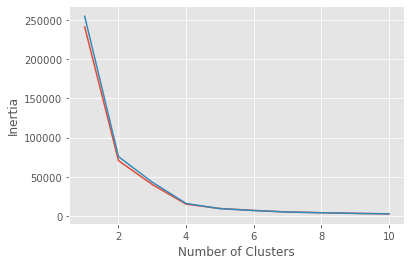

In [72]:
lows=pd.DataFrame(data=data,index=data.index,columns=['Low'])
highs=pd.DataFrame(data=data,index=data.index,columns=['High'])

low_clusters=get_optimum_clusters(lows)
low_centers=low_clusters.cluster_centers_
low_centers=np.sort(low_centers,axis=0)


high_clusters=get_optimum_clusters(highs)
high_centers=high_clusters.cluster_centers_
high_centers=np.sort(high_centers,axis=0)

#note as there are 2 graphs overlapping they end up reaching saturation at the end

In [73]:
def plot_stock_data(data,low_centers,high_centers):
    df_ohlc=pd.DataFrame(index=np.arange(len(data)))
    df_ohlc['Date']=(data.index).map(mdates.date2num)
    df_ohlc['Open']=data['Open'].values
    df_ohlc['High']=data['High'].values
    df_ohlc['Low']=data['Low'].values
    df_ohlc['Close']=data['Close'].values
    
    
    plt.figure(figsize=(40,10))
    ax1=plt.axes()
    ax2=plt.axes()
    
    ax1.xaxis_date()
    candlestick_ohlc(ax1,df_ohlc.values,width=1,colorup='g',colordown='r')
    
#     ax1.set_ylabel('Date')
#     ax1.set_ylabel('Price')
    
    
    ax2.xaxis_date()
    ax2.plot([df_ohlc['Date'][0],df_ohlc['Date'][len(df_ohlc)-1]],[low_centers[0],low_centers[0]], color='orange', linestyle='--',label='Support')
    for low in low_centers[1:]:
        ax2.plot([df_ohlc['Date'][0],df_ohlc['Date'][len(df_ohlc)-1]],[low,low], color='orange', linestyle='--')
    
    #Need to put if condition to limit the number of supports and resistances
    ax2.plot([df_ohlc['Date'][0],df_ohlc['Date'][len(df_ohlc)-1]],[high_centers[0],high_centers[0]], color='black', linestyle='--',label='Resistance')
    for high in high_centers[1:]:
        ax2.plot([df_ohlc['Date'][0],df_ohlc['Date'][len(df_ohlc)-1]],[high,high], color='black', linestyle='--')
    plt.legend()

C:\Users\User\miniconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


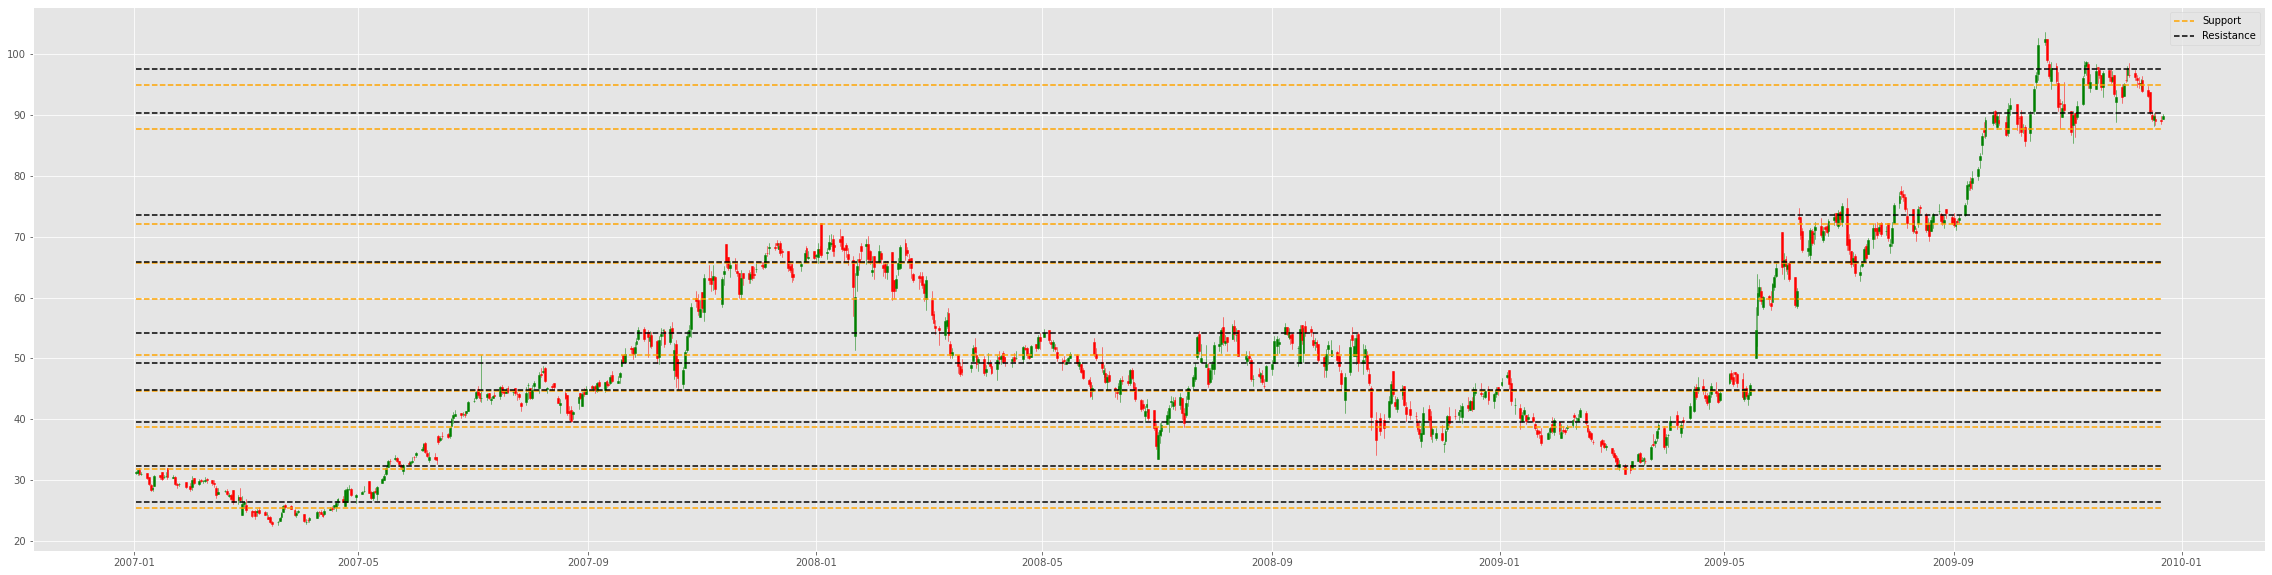

In [74]:
plt.style.use('ggplot')
plot_stock_data(data,low_centers,high_centers)

#plotting the data